#CafChem tools for using various gradient boosting machine learning models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/Boost_CafChem.ipynb)

## This notebook allows you to:
- load a CSV and featurize a SMILES dataset with RDKit or Mordred descriptors or Fingerprints.
- Fit a gradient boosting model with XGBoost, CatBoost or LightGBM.
- Classification and Regression.
- Perform gridsearch with CV.

## Requirements:
- This notebook will install rdkit.
- Runs on CPU or your local runtime.

## Set-up
- install rdkit
- import libarries

In [1]:
!pip install -q rdkit
!pip install -q catboost
!pip install -q deepchem
!pip install -q mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-pytho

In [5]:
## ONLY NEEDED ON CURRENT COLAB (OCTOBER 2025)
!pip install "numpy>=2.0.0,<2.3.0" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 111.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mordred 1.2.0 requires numpy==1.*, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
nx-cugraph-cu12 25.6.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.


In [2]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 1108, done.
remote: Counting objects: 100% (430/430), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1108 (delta 371), reused 257 (delta 257), pack-reused 678 (from 1)
Receiving objects: 100% (1108/1108), 57.35 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (652/652), done.
Updating files: 100% (90/90), done.


In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors

import CafChem.CafChemBoost as ccb

## Classification

### Read data from CSV, featurize

In [4]:
df = ccb.make_classes('/content/905-unique-statins.csv', 'IC50 (nM)', 3)
df.head()

Samples per class: 301, total samples:905


,Unnamed: 0,Ligand SMILES,IC50 (nM),class labels
0,7,CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])=O)c(c...,0.106,0.106 < 15.0
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200,0.106 < 15.0
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300,0.106 < 15.0
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300,0.106 < 15.0
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300,0.106 < 15.0


In [5]:
X, y, smiles = ccb.featurize(df['Ligand SMILES'], df['class labels'])

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


In [6]:
X_train, X_test, y_train, y_test, smiles_train, smiles_test, pca, scaler = ccb.scale_pca_split(X,y, smiles)

target converted to ints
Pre-processing done.


### XGBoost single

In [7]:
xgb = ccb.Boost_methods('XGBoost', True)
model, train_score, test_score = xgb.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
model selected:  XGBoost Classifier
[16:32:52] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (814, 217, 176638).
fit model in: 0.30464451191666625 minutes
score for training set: 0.991
score for validation set: 0.747


### XGBoost Grid search with CV

In [8]:
search_grid = [
    {'n_estimators': [100],
     'learning_rate': [0.01, 1.0],
     'max_depth': [20]
    }
]

In [9]:
xgb = ccb.Boost_methods('XGBoost', True)
best_params, best_score = xgb.grid_search(X, y, search_grid)

Gradient Boosting Regression (classification) class initialized.
Performing grid search on:  XGBoost Classifier
target converted to ints
[16:34:21] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (905, 217, 196385).
 Best parameters: {'learning_rate': 1.0, 'max_depth': 20, 'n_estimators': 100} and best score: 0.737.


### Light GBM Single model

In [10]:
lgbm = ccb.Boost_methods('LightGBM', True)
model, train_score, test_score = lgbm.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
model selected:  LightGBM Classifier
fit model in: 0.04341438466666811 minutes
score for training set: 0.991
score for validation set: 0.736


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Light GBM Grid search with CV

In [13]:
search_grid = [
    {'num_leaves': [32],
     'feature_fraction': [0.5,1.0],
     'min_data_in_leaf': [10, 50]
    }
]

In [14]:
lgbm = ccb.Boost_methods('LightGBM', True)
best_params, best_score = lgbm.grid_search(X, y, search_grid)

Gradient Boosting Regression (classification) class initialized.
Performing grid search on:  LightGBM Classifier
target converted to ints
 Best parameters: {'feature_fraction': 0.5, 'min_data_in_leaf': 50, 'num_leaves': 32} and best score: 0.741.


### CatBoost Single model

In [15]:
cb = ccb.Boost_methods('CatBoost', True)
model, train_score, test_score = cb.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
model selected:  CatBoost Classifier
fit model in: 0.08625689006666638 minutes
score for training set: 0.867
score for validation set: 0.725


### CatBoost Gridsearch with CV

In [16]:
search_grid = [
    {'iterations': [100],
     'learning_rate': [0.01, 0.1],
     'max_depth': [7]
    }
]

In [17]:
cb = ccb.Boost_methods('CatBoost', True)
best_params, best_score = cb.grid_search(X, y, search_grid)

Gradient Boosting Regression (classification) class initialized.
Performing grid search on:  CatBoost Classifier
target converted to ints


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Best parameters: {'iterations': 100, 'learning_rate': 0.1, 'max_depth': 7} and best score: 0.744.


### Evaluate Classification

In [11]:
labels = df['class labels'].unique()
labels = list(labels)
print(labels)

['0.106 < 15.0', '15.0 < 1000.0', '1000.0 < 2488000.0']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


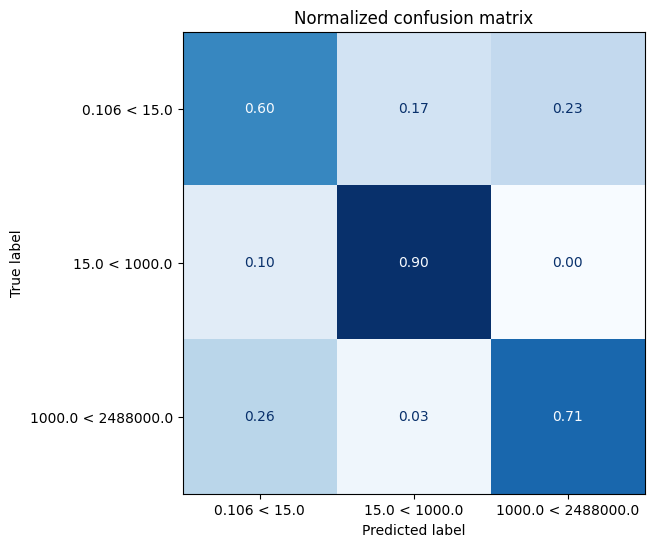

In [12]:
test_boost = ccb.evaluate(model, labels, X_test, y_test)
test_boost.confusion()

## Regression

In [18]:
df = pd.read_csv("/content/905-unique-statins.csv")
df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [19]:
X, y, smiles = ccb.featurize(df['Ligand SMILES'], df['IC50 (nM)'])

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


In [20]:
y = [np.log10(x) for x in y]

In [21]:
X_train, X_test, y_train, y_test, smiles_train, smiles_test, pca, scaler = ccb.scale_pca_split(X,y, smiles)

Pre-processing done.


### XGBoost Regression

In [22]:
xgb = ccb.Boost_methods('XGBoost', learning_rate = 0.1, max_depth=10, n_estimators=100)
model, train_score, test_score = xgb.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
model selected:  XGBoost Regressor
[16:38:54] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (814, 217, 176638).
fit model in: 0.14340912631666736 minutes
score for training set: 0.998
score for validation set: 0.654


### XGBoost gridsearch CV

In [23]:
search_grid = [
    {'n_estimators': [100],
     'learning_rate': [0.01, 0.1],
     'max_depth': [25]
    }
]

In [24]:
xgb = ccb.Boost_methods('XGBoost')
best_params, best_score = xgb.grid_search(X, y, search_grid)
print(f"Running model with best parameters and Train/Test split =================")
xgb = ccb.Boost_methods('XGBoost', learning_rate = best_params['learning_rate'], max_depth=best_params['max_depth'],
                        n_estimators=best_params['n_estimators'])
model, train_score, test_score = xgb.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
Performing grid search on:  XGBoost Regressor
[16:40:59] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (905, 217, 196385).
 Best parameters: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 100} and best score: -3.859.
Running model with best parameters and Train/Test split =================
Gradient Boosting Regression (classification) class initialized.
model selected:  XGBoost Regressor
[16:41:16] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (814, 217, 176638).
fit model in: 0.2786077356166667 minutes
score for training set: 0.998
score for validation set: 0.626


### LightGBM Regression

In [25]:
lgbm = ccb.Boost_methods('LightGBM')
model, train_score, test_score = lgbm.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
model selected:  LightGBM Regressor
fit model in: 0.014010836766666064 minutes
score for training set: 0.989
score for validation set: 0.689


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### LightGBM Gridsearch

In [26]:
search_grid = [
    {'num_leaves': [32],
     'feature_fraction': [0.5,1.0],
     'min_data_in_leaf': [25]
    }
]

In [27]:
lgbm = ccb.Boost_methods('LightGBM')
best_params, best_score = lgbm.grid_search(X, y, search_grid)
print(f"Running model with best parameters and Train/Test split =================")
lgbm = ccb.Boost_methods('LightGBM', num_leaves = best_params['num_leaves'], feature_fraction = best_params['feature_fraction'],
                        min_data_in_leaf = best_params['min_data_in_leaf'])
model, train_score, test_score = lgbm.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
Performing grid search on:  LightGBM Regressor
 Best parameters: {'feature_fraction': 1.0, 'min_data_in_leaf': 25, 'num_leaves': 32} and best score: -3.697.
Running model with best parameters and Train/Test split =================
Gradient Boosting Regression (classification) class initialized.
model selected:  LightGBM Regressor
fit model in: 0.011299944500001402 minutes
score for training set: 0.982
score for validation set: 0.673


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Catboost regression

In [28]:
cb = ccb.Boost_methods('CatBoost')
model, train_score, test_score = cb.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
model selected:  CatBoost Regressor
fit model in: 0.03688429596666841 minutes
score for training set: 0.839
score for validation set: 0.720


In [29]:
search_grid = [
    {'iterations': [100],
     'learning_rate': [0.01, 0.1],
     'max_depth': [7]
    }
]

In [30]:
cb = ccb.Boost_methods('CatBoost')
best_params, best_score = cb.grid_search(X, y, search_grid)
print(f"Running model with best parameters and Train/Test split =================")
cb = ccb.Boost_methods('CatBoost', iterations = best_params['iterations'], learning_rate = best_params['learning_rate'],
                        max_depth = best_params['max_depth'])
model, train_score, test_score = cb.fit(X_train, X_test, y_train, y_test)

Gradient Boosting Regression (classification) class initialized.
Performing grid search on:  CatBoost Regressor
 Best parameters: {'iterations': 100, 'learning_rate': 0.1, 'max_depth': 7} and best score: -3.243.
Running model with best parameters and Train/Test split =================
Gradient Boosting Regression (classification) class initialized.
model selected:  CatBoost Regressor
fit model in: 0.036343264366666975 minutes
score for training set: 0.914
score for validation set: 0.741


### Evaluate regression

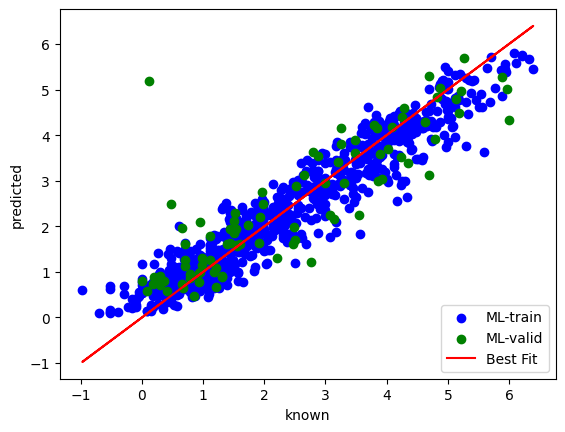

In [31]:
ccb.plot_predictions(model, X_train, y_train, X_test, y_test)

In [32]:
pred = ccb.predict_with_model(['c1ccc(F)cc1'], model, "rdkit", scaler)
pred = 10**pred
print(f"Prediction is {pred[0]}")

Prediction is 267092.82183628896
